In [1]:
from sklearn.cluster import KMeans
import sys
# sys.path.insert(1, '../permus_util')
# sys.path.insert(0, '/Users/ekhi/Desktop/gits/top-k-mallows')

import mallows_kendall as mk
import permutil as pu
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data description

This dataset has been generated a collection of students of 'Ecomomics and Enterprise' in Tecnun. Each student provides a ranking of 4 words in order of similarity to the word 'Amortización' (amortization). The words are: 'Depreciación' (depreciation), 'Gasto' (expense), 'Vida útil' (lifetime), 'Pago' (payment). There exists a real ground-true ranking, which is denoted along the experiment as $s0$, $s0=$['Depreciación', 'Gasto', 'Vida útil', 'Pago'] = [0,1,2,3].

There are two different samples in this dataset:

- sample 1: the experiment is carried out **before** the class, 
- sample 2: the experiment is carried out **after** the class.


The questions that we try to solve are:

- Do the students *learn* in the class? Do the answers after the class closer to the ground-true ranking?
- In general, we have access to the sample but do not have access to the ground-true answer. Can we separete the expert students from the non-expert students with statistics from the sample (with out knowing $s0$?

## References

This work is a real-word experimental evaluation of WP ??? in the project SENDAI (Eklartek program). The theoretical background can be found in \[2].


- \[1]  A Learning Theory of Ranking Aggregation
Anna Korba, Stéphan Clemencon, Eric Sibony. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, PMLR 54:1001-1010, 2017.
- \[2] Concentric mixtures of Mallows models for top-k rankings: sampling and identifiability. Fabien Collas, Ekhine Irurozki. https://arxiv.org/abs/2010.14260 

In [2]:
def format_df(df):
    a = ['Depreciación', 'Gasto', 'Vida útil', 'Pago']
    df = df.replace('Depreciación',0)
    df = df.replace('Gasto',1)
    df = df.replace('Vida útil',2)
    df = df.replace('Pago',3)
    df.values
    return df

df = pd.read_csv('./tecnun_consensus.csv', header=None,sep=';')
s0 = np.argsort(format_df(df).values[0])
df = pd.read_csv('./tecnun_data1.csv', header=None,sep=';')
d1 = np.argsort(format_df(df).values[:,:4])
df = pd.read_csv('./tecnun_data2.csv', header=None,sep=';')
d2 = np.argsort(format_df(df).values[:,:4])
print("The ground-true ranking is",s0)

The ground-true ranking is [0 1 2 3]


# Improvement after class

The fist question is to analyze wheter the students' answers improved by taking the class. The most direct approach is to measure 

- the distance between the average ranking of the student **before** the class and the ground-true ranking ($s0$) and
- the distance between the average ranking of the student **after** the class and the ground-true ranking ($s0$).

The average ranking before the class was further than the average distance after the class. Therefore, we can conclude that the students did learn in the class. 


In [3]:
avg_ranking_before = np.argsort(np.argsort(d1.sum(axis=0)))
avg_ranking_after = np.argsort(np.argsort(d2.sum(axis=0)))
print("The distance of the average ranking before the class is", mk.distance(s0,avg_ranking_before))
print("The distance of the average ranking before the class is", mk.distance(s0,avg_ranking_after))
print("Did the students learn?", mk.distance(s0,avg_ranking_before) > mk.distance(s0,avg_ranking_after))


The distance of the average ranking before the class is 2
The distance of the average ranking before the class is 1
Did the students learn? True


# Distance to the sample (type-A depth)

We know that if the ranking provided by student $a$ is closer to the center ($s0$) than the ranking provided by student $b$ then student $a$ is *more expert/better* than student $b$. However, in general, we will not have access to $s0$ (nor to the distance to the center $s0$). Is it still possible to measure how good a student's ranking is?

In the follwing experiment, we consider two different measures for each ranking (i.e., student) in the sample:

- Distance to the center: given that the center is known (i.e., the ground true ranking), we can measure the quality of each student as the (Kendall's-$\tau$) distance between the ranking provided by the student and the ground true ranking.
- Distance to the the sample: for each student, we measure the sum of the (Kendall's-$\tau$) distances between his/her ranking and the rest of the rankings in the sample. 

Under certain conditions both measures are correlated, \[1,2]. In this experiment, we plot each ranking as a dot in coordinates (x,y) where *x* is the 'Distance to the the sample' and *y* the 'Distance to the center'. Moreover, we fit a linear regression model between the two variables. We see that for this real data both measures are also correlated, which suggests that we can estimate the distance to the ground-true ranking with the distance to the sample. 


**Note**: the depth of a ranking is the maximum distance minus the sum of the distances to the sample. 


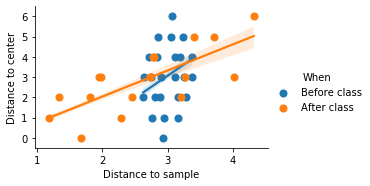

In [4]:
palette1 = sns.color_palette("tab10", 2)
palette2 = sns.color_palette("husl", 2)
def gen_df(data,when):
    res = []
    P = pu.sample_to_marg_rel(data)
    for perm_ind in range(len(data)):
        perm = data[perm_ind]
        res.append([mk.distance(s0, perm), pu.dist_to_sample(perm,P)  ])
    df = pd.DataFrame(res,columns=['Distance to center','Distance to sample'])
    df['When'] = when
    return df
df1 = gen_df(d1,'Before class')
df2 = gen_df(d2,'After class')
df = pd.concat([df1,df2])
ax = sns.lmplot(x="Distance to sample", y="Distance to center", data=df,hue='When',
           x_estimator=np.mean,palette=palette1, height=2.5, aspect=1.5)

## Visualizing groups
When the set of students is heterogeneous (there are two different groups of good and bad students) then the 'distance to the sample' of a ranking provided by a good student will be very different from the 'distance to the sample' of a ranking provided by a bad student \[2]. In the following plots, we see the histograms of the 'distance to the sample' of both groups. 

We see that before the class (blue data) there is one component, which suggests that the group is homogeneous and noisy (close to uniform). However, after the class, there are different groups that are identified by the different peaks in the orange data: some of the students are close to the center (are experts) and some provided uniform rankings (non-expert).

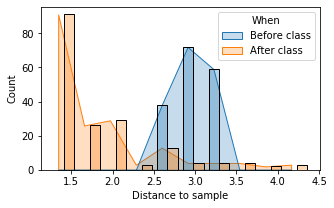

In [5]:
fig, ax = plt.subplots(1, 1,figsize=(5,3))
sns.histplot(data=df, x="Distance to sample", hue="When", multiple="dodge", 
             shrink=.8, alpha=0.3,palette=palette1, ax=ax)
a = sns.histplot(data=df, x="Distance to sample", hue="When", element="poly",
             palette=palette1, ax=ax)

## Clustering: finding the good and bad student in the group after-class
In the following, we only consider the group **after-class**. We see in the previous plot that this is a hetereogeneos group, where there are experts and non-experts. In this section, we separete both groups based on the 'Distance to sample'. 

When the students inside one group are *different enought*, a clustering algorithm can separate the expert from the non-expert students in the group (a bound for this difference is given in  \[2]). In the next figure, we show that a clustering algorithms (an off-the-shelf KMeans) can separare the good (red) and the bad (green) students. The clustering of the group is visualized in the following figure. 

> **We conclude by noting that we have separated the experts from the non-expert student using sample statistics (i.e., using the 'Distance to sample' and without knowing the center $s0$). This result is consistent with the theoretical findings in \[2].**



The distance of cluster 0 is 4
The distance of cluster 1 is 5


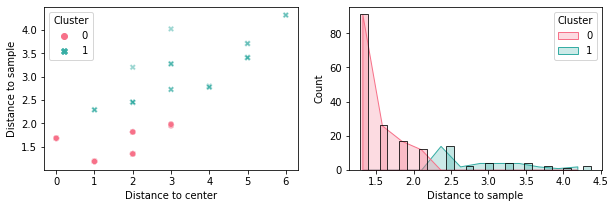

In [6]:
Xafter = df[df.When=='After class'].copy()
Xafter['Distance to sample']
Xafter['Distance to sample'].values.reshape(-1,1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xafter['Distance to sample'].values.reshape(-1,1))
Xafter['Cluster'] = kmeans.labels_
fig, ax = plt.subplots(1, 2,figsize=(10,3))
sns.scatterplot(data=Xafter, x="Distance to center", y="Distance to sample",
                hue='Cluster',style='Cluster',alpha=.5,palette=palette2,ax=ax[0])
sns.histplot(data=Xafter, x="Distance to sample", hue="Cluster", multiple="dodge", 
             shrink=.8, alpha=0.3,palette=palette2,ax=ax[1])
sns.histplot(data=Xafter, x="Distance to sample", hue="Cluster",element="poly",
             palette=palette2,ax=ax[1])
c1 = np.argsort(np.argsort(d1[Xafter['Cluster']].sum(axis=0)))
c0 = np.argsort(np.argsort(d1[1-Xafter['Cluster']].sum(axis=0)))
print("The distance of cluster 0 is", mk.distance(s0,c0))
print("The distance of cluster 1 is", mk.distance(s0,c1))